<hr>
<br><br>
<center>

<img src="https://upload.wikimedia.org/wikipedia/fr/thumb/c/c0/Logo_ENSAI_2014.svg/1400px-Logo_ENSAI_2014.svg.png?20190428210651"  width = 548 height=250>

<br><br>
<h1> Master for Smart Data Science </h1>
<h2> Spark Project</h2>
<br><br>

</center>

<h3> Alessio Crisafulli Carpani </h3>

<hr>



# Setup

In [1]:
# General ---
import random

random.seed(42)
%precision %.2f
import warnings

warnings.filterwarnings("ignore")
print("─" * 35)
# --------------

# Pandas --------------------------------------------
import pandas as pd

print(
    "The"
    + "\x1b[1;32;30m"
    + " pandas "
    + "\x1b[0m"
    + "version is {:>11}.".format(pd.__version__)
)
pd.set_option("display.precision", 3)
pd.reset_option("display.precision")
pd.options.display.float_format = "{:.1f}".format
pd.set_option("colheader_justify", "left")
pd.options.display.max_rows = 20
pd.options.display.max_columns = None
pd.options.display.date_dayfirst = True
pd.set_option("display.max_colwidth", 45)
pd.set_option("display.html.table_schema", True)
# ----------------------------------------------------

# Numpy ---------------------------------------------
import numpy as np

print(
    "The"
    + "\x1b[1;32;30m"
    + " numpy "
    + "\x1b[0m"
    + "version is {:>13}.".format(np.__version__)
)
np.set_printoptions(suppress=True, precision=3)
# ----------------------------------------------------

# Matplotlib ------------------------------------------
import matplotlib as mpl

print(
    "The"
    + "\x1b[1;32;30m"
    + " matplotlib "
    + "\x1b[0m"
    + "version is {:>7}.".format(mpl.__version__)
)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.style.use(["seaborn"])
sns.set_context("notebook", font_scale=1.1)
sns.set(
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    }
)
sns.set_context(
    "notebook", rc={"font.size": 12, "axes.titlesize": 16, "axes.labelsize": 10}
)
mpl.rcParams["figure.figsize"] = [6.0, 4.0]
mpl.rcParams["figure.dpi"] = 130
mpl.rcParams["savefig.dpi"] = 100
mpl.rcParams["font.size"] = 10
mpl.rcParams["legend.fancybox"] = False
mpl.rcParams["legend.loc"] = "upper right"
mpl.rcParams["legend.numpoints"] = 2
mpl.rcParams["legend.fontsize"] = "small"
mpl.rcParams["legend.framealpha"] = None
mpl.rcParams["legend.scatterpoints"] = 3
mpl.rcParams["legend.edgecolor"] = "inherit"
mpl.rcParams["figure.titlesize"] = "medium"
# ------------------------------------------------------
print("─" * 35)

───────────────────────────────────
The pandas version is       1.3.5.
The numpy version is        1.21.6.
The matplotlib version is   3.2.2.
───────────────────────────────────


In [2]:
%%capture
!pip install pyspark
!pip install pgeocode

In [3]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
       .master("local[2]") \
       .appName("PySpark-Colab") \
       .config('spark.ui.port', '4050') \
       .config("spark.driver.memory", "8g") \
       .getOrCreate()
sc = spark.sparkContext
spark

In [ ]:
%%capture
# Load SPARK UI from Colab
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# Need the ngrok.com service
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
!./ngrok authtoken '<Your AuthToken>'
get_ipython().system_raw('./ngrok http 4050 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://60cb-35-245-240-231.ngrok.io


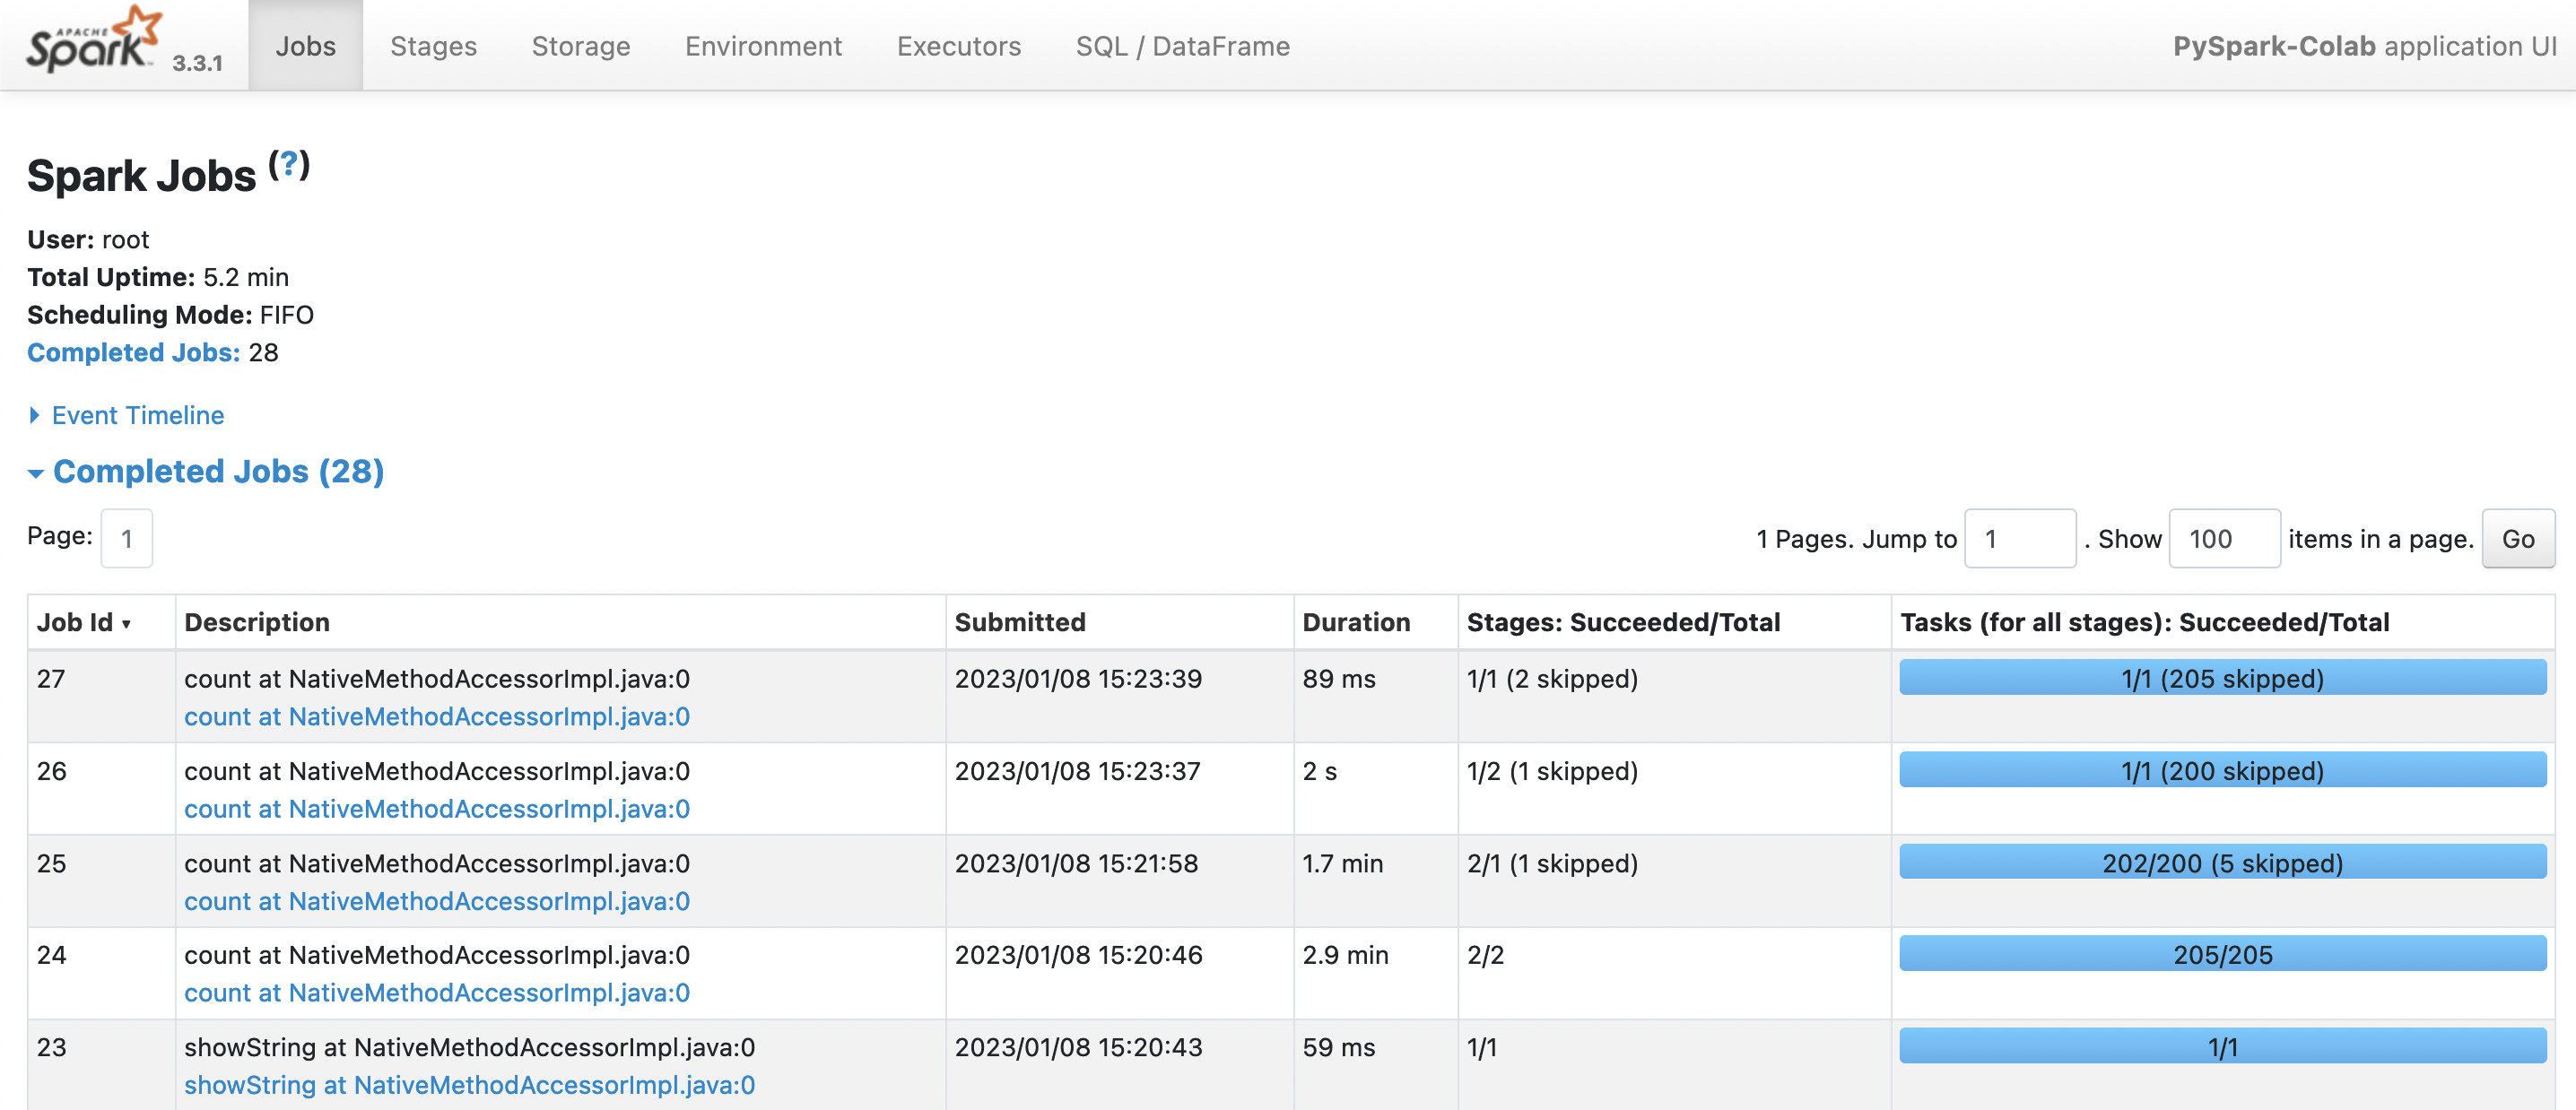

# Reading Data

These are data files transformed from XML for easier sessions.

## Gas Prices

* Delimiter is ;
* No header is provided

Fields are in this order:
- id pdv (point of sales),
- cp (zip code),
- pop (type of population, R: rural, A: urban, etc.)
- latitude
- longitude
- date
- id carburant (gas id)
- nom carburant (gas label)
- prix (price in millieuros)

Here in order to collect data from a **Github** repository, I am going to call a `shell script` to do the job for the different files. 

I will create a new directory *'Prix'* where I will save the file with the same structure

In [4]:
%%capture
%%shell

for year in {2016..2021}
do wget -O Prix"$year".csv.gz https://github.com/rvm-courses/GasPrices/blob/master/Prix"$year".csv.gz?raw=true
done

for semester in "S1" "S2"
do wget -O Prix2022"$semester".csv.gz https://github.com/rvm-courses/GasPrices/blob/master/Prix2022"$semester".csv.gz?raw=true
done

wget -O Stations2022.csv.gz https://github.com/rvm-courses/GasPrices/blob/master/Stations2022.csv.gz?raw=true
wget -O Services2022.csv.gz https://github.com/rvm-courses/GasPrices/blob/master/Services2022.csv.gz?raw=true


In [5]:
from pyspark.sql.types import *
import os

os.listdir()

# Create list of file we want to read
files = [
    "Prix2018.csv.gz",
    "Prix2022S2.csv.gz",
    "Prix2021.csv.gz",
    "Prix2017.csv.gz",
    "Prix2019.csv.gz",
    "Prix2022S1.csv.gz",
    "Prix2020.csv.gz",
    "Prix2016.csv.gz",
]

# Initiate a dictionary to store values
datasets = {}
# Read each file and store it as a key
for file in files:
    datasets[file.split(".")[0]] = spark.read.csv(
        file,
        sep=";",
        schema=StructType(
            [
                StructField("id_pdv", StringType()),
                StructField("zip", StringType()),
                StructField("pop", StringType()),
                StructField("latitude", FloatType()),
                StructField("longitude", FloatType()),
                StructField("date", TimestampType()),
                StructField("id_gas", IntegerType()),
                StructField("gas_label", StringType()),
                StructField("price", FloatType()),
            ]
        ),
    )

datasets

{'Prix2018': DataFrame[id_pdv: string, zip: string, pop: string, latitude: float, longitude: float, date: timestamp, id_gas: int, gas_label: string, price: float],
 'Prix2022S2': DataFrame[id_pdv: string, zip: string, pop: string, latitude: float, longitude: float, date: timestamp, id_gas: int, gas_label: string, price: float],
 'Prix2021': DataFrame[id_pdv: string, zip: string, pop: string, latitude: float, longitude: float, date: timestamp, id_gas: int, gas_label: string, price: float],
 'Prix2017': DataFrame[id_pdv: string, zip: string, pop: string, latitude: float, longitude: float, date: timestamp, id_gas: int, gas_label: string, price: float],
 'Prix2019': DataFrame[id_pdv: string, zip: string, pop: string, latitude: float, longitude: float, date: timestamp, id_gas: int, gas_label: string, price: float],
 'Prix2022S1': DataFrame[id_pdv: string, zip: string, pop: string, latitude: float, longitude: float, date: timestamp, id_gas: int, gas_label: string, price: float],
 'Prix2020':

> Now that we have downloaded all the DataFrames, we may be interested in the number of rows and it could be useful to print the first row to visualize each file

In [ ]:
for DataFrame in datasets.keys():
    print("─" * 75)
    print("Number of rows in " + "\x1b[1;32;30m" + DataFrame + "\x1b[0m","=", datasets[DataFrame].count())
    datasets[DataFrame].show(1)

───────────────────────────────────────────────────────────────────────────
Number of rows in Prix2018 = 3885692
+-------+-----+---+---------+---------+-------------------+------+---------+------+
| id_pdv|  zip|pop| latitude|longitude|               date|id_gas|gas_label| price|
+-------+-----+---+---------+---------+-------------------+------+---------+------+
|1000001|01000|  R|4620114.0| 519791.0|2018-01-06 12:20:27|     1|   Gazole|1376.0|
+-------+-----+---+---------+---------+-------------------+------+---------+------+
only showing top 1 row

───────────────────────────────────────────────────────────────────────────
Number of rows in Prix2022S2 = 2304432
+-------+-----+---+---------+---------+-------------------+------+---------+-----+
| id_pdv|  zip|pop| latitude|longitude|               date|id_gas|gas_label|price|
+-------+-----+---+---------+---------+-------------------+------+---------+-----+
|1000001|01000|  R|4620100.0| 519800.0|2022-07-01 11:23:43|     1|   Gazole| 2.

Here we can see that the *price* (_c8) column must be divided by the power of three for the datasets prior to 2022

In [6]:
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql.functions import col, udf


for DataFrame in [
    "Prix2016",
    "Prix2017",
    "Prix2018",
    "Prix2019",
    "Prix2020",
    "Prix2021",
]:
    datasets[DataFrame] = datasets[DataFrame].withColumn(
        "price", F.col("price") / 10**3
    )

## Stations and Services

**Stations Files**

* Delimiter is |
* No header is provided

- id pdv,
- cp (zip code)
- pop (type of population, R: rural, A: urban, etc.)
- latitude
- longitude
- adresse (address)
- ville (city)

Note : may require to set PYTHONIOENCODING=utf-8 on Windows for special French characters.

**Services Files**

* Delimiter is |
* No header is provided

Files are in this order:
- id_pdv (point of sales),
- cp_pdv (zip code),
- pop (type of population, R: rural, A: urban, etc.),
- latitude,
- longitude,
- services (as a string of services list in natural language)

Please see additional references at http://www.prix-carburants.gouv.fr/rubrique/opendata/

In [ ]:
services = spark.read.csv(
    "Services2022.csv.gz",
    sep="|",
    schema=StructType(
        [
            StructField("id_pdv", StringType()),
            StructField("zip", StringType()),
            StructField("pop", StringType()),
            StructField("latitude", StringType()),
            StructField("longitude", StringType()),
            StructField("service", StringType()),
        ]
    ),
)

In [ ]:
stations = spark.read.csv(
    "Stations2022.csv.gz",
    sep="|",
    schema=StructType(
        [
            StructField("id_pdv", StringType()),
            StructField("zip", StringType()),
            StructField("pop", StringType()),
            StructField("latitude", StringType()),
            StructField("longitude", StringType()),
            StructField("address", StringType()),
            StructField("city", StringType()),
        ]
    ),
)

# Data Manipulation

Fow now on, I will focus on the data from 2019 to 2022 as the computational time is going to be relevant.

## Merge Data

In [7]:
data = datasets["Prix2019"].union(datasets["Prix2020"])
data = data.union(datasets["Prix2021"])
data = data.union(datasets["Prix2022S1"])
data = data.union(datasets["Prix2022S2"])

# Remove duplicates and remove NAs
data = data.distinct().dropna().cache()

print("Total number of rows:", data.count())
print("Total number of columns:", len(data.columns))

Total number of rows: 17286171
Total number of columns: 9


## Split the date

In [8]:
data = (
    data.withColumn("year", year(col("date")))
    .withColumn("month", month(col("date")))
    .withColumn("day", dayofmonth(col("date")))
    .withColumn("week", weekofyear(col("date")))
).drop("date")

## Fix latitude and longitude

In [9]:
data = data.withColumn("latitude", col("latitude") / 10**5)
data = data.withColumn("longitude", col("longitude") / 10**4)

## SQL Context

In [10]:
data.createOrReplaceTempView("database")
spark.sql("SELECT * FROM database").show(1)

+-------+-----+---+--------+---------+------+---------+-----+----+-----+---+----+
| id_pdv|  zip|pop|latitude|longitude|id_gas|gas_label|price|year|month|day|week|
+-------+-----+---+--------+---------+------+---------+-----+----+-----+---+----+
|1000001|01000|  R|46.20114|  51.9791|     1|   Gazole|1.371|2019|    7| 27|  30|
+-------+-----+---+--------+---------+------+---------+-----+----+-----+---+----+
only showing top 1 row



# Data Engineering

In [11]:
# Compute average gas price by type and date
data = spark.sql(
    """
    SELECT *, AVG(price) 
    OVER (PARTITION BY gas_label, year, month, day) 
    AS price_avg
    FROM database
    """
)

#avg = data.groupBy("gas_label", "year", "month", "day").mean("price")
#data = data.join(avg, ["gas_label", "year", "month", "day"]).cache()

In [12]:
# Compute price_index
data = data.withColumn(
    "price_index", 100 * ((F.col("price") - col("price_avg")) / col("price_avg") + 1)
)


In [13]:
# Get week_index 
data = (
    data.withColumn("week_index", (col("year") - 2019) * 52 + col("week"))
    .sort("year")
    .drop("avg(price)")
)

In [14]:
# Construct season column
season = udf(lambda x: x % 12 // 3 + 1, IntegerType())
data = data.withColumn("season", season(col("month")))

In [15]:
data.show()
data.explain()

+--------+-----+---+---------+---------------+------+---------+-----+----+-----+---+----+------------------+------------------+----------+------+
|  id_pdv|  zip|pop| latitude|      longitude|id_gas|gas_label|price|year|month|day|week|         price_avg|       price_index|week_index|season|
+--------+-----+---+---------+---------------+------+---------+-----+----+-----+---+----+------------------+------------------+----------+------+
| 8000005|08000|  R| 49.76736|        47.1736|     5|      E10|1.389|2019|    1|  7|   2|1.3927100770003353| 99.73360737014798|         2|     1|
|21110003|21110|  R| 47.24021|        52.1954|     5|      E10|1.429|2019|    1|  7|   2|1.3927100770003353| 102.6057054945583|         2|     1|
|38300004|38300|  R| 45.58556|        52.6444|     5|      E10|1.364|2019|    1|  7|   2|1.3927100770003353| 97.93854604239154|         2|     1|
|44370009|44370|  A| 47.41962|-10.14541015625|     5|      E10|1.494|2019|    1|  7|   2|1.3927100770003353|107.272864946725

# Data Visualization

## Gas Prices over Time

In [ ]:
# Average Gas prices for each gas type over the week index
df_avg = (
    data.groupBy("gas_label", "week_index")
    .mean("price")
    .sort("gas_label", "week_index")
).toPandas()

In [ ]:
df_avg1 = df_avg[~np.isin(df_avg['gas_label'], ["E85", "GPLc"])]
df_avg2 = df_avg[np.isin(df_avg['gas_label'], ["E85", "GPLc"])]

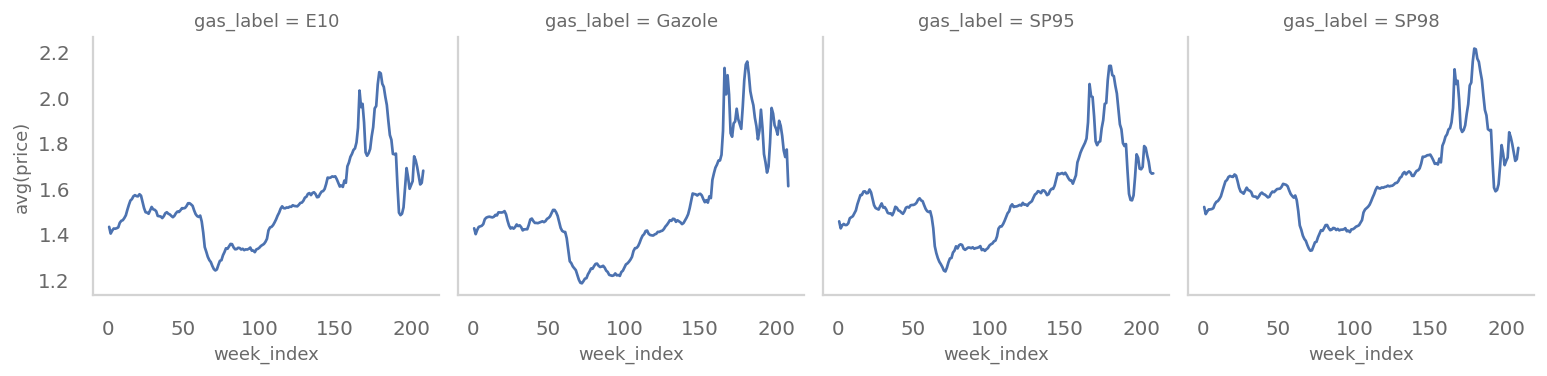

In [ ]:
g = sns.FacetGrid(df_avg1, col="gas_label")
g = g.map(sns.lineplot, "week_index", "avg(price)", markers=True)

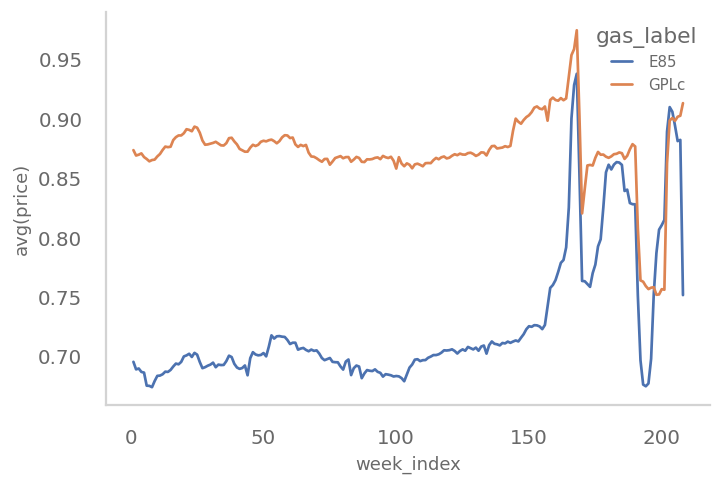

In [ ]:
sns.lineplot(
    data=df_avg2,
    x="week_index", y="avg(price)", hue="gas_label",
    markers=True, dashes=False
);

## Choropleth Map by Departments

In [ ]:
# Extract first two digits of zip code to get the department code
dpt = data.withColumn("dept_code", substring(F.col("zip"),1,2))
dpt.show(1)

+-------+-----+---+--------+---------+------+---------+-----+----+-----+---+----+------------------+-----------------+----------+------+---------+
| id_pdv|  zip|pop|latitude|longitude|id_gas|gas_label|price|year|month|day|week|         price_avg|      price_index|week_index|season|dept_code|
+-------+-----+---+--------+---------+------+---------+-----+----+-----+---+----+------------------+-----------------+----------+------+---------+
|8000005|08000|  R|49.76736|  47.1736|     5|      E10|1.389|2019|    1|  7|   2|1.3927100770003353|99.73360737014798|         2|     1|       08|
+-------+-----+---+--------+---------+------+---------+-----+----+-----+---+----+------------------+-----------------+----------+------+---------+
only showing top 1 row



In [ ]:
%%time
# Get the average price_index by gas type and department
dpt.createOrReplaceTempView("dpt")
dpt = spark.sql(
    """
    SELECT gas_label, dept_code, AVG(price_index) 
    OVER (PARTITION BY gas_label, dept_code) 
    AS price_index_avg
    FROM dpt
    WHERE gas_label = 'SP95';
    """
).toPandas()

In [ ]:
# Simplify the pandas dataframe for plotting
dpt = dpt.groupby("dept_code").mean('price_index_avg').reset_index()

In [ ]:
%%capture
!wget -O departements.geojson https://france-geojson.gregoiredavid.fr/repo/departements.geojson

In [ ]:
import folium

# Inititate a folium map
m = folium.Map(
    location=[46.5, 2.3],
    zoom_start=6,
    tiles=None,
)

# Add background
folium.TileLayer("CartoDB positron", name="Light Map", control=False).add_to(m)

# Draw the Choropleth
folium.Choropleth(
    geo_data='departements.geojson', 
    data=dpt,
    columns=['dept_code', 'price_index_avg'], 
    key_on='feature.properties.code',
    fill_color='RdGy',
    fill_opacity=0.5,
    line_opacity=0.8,
    legend_name='Price Index',
).add_to(m)

m

### Using a geocoding UDF

In [ ]:
%%time
import pgeocode

# Prepare geocoding with french locale
geo = pgeocode.Nominatim("fr")
# create user defined function (udf) that geocodes zip into department code
geocode = udf(lambda x: geo.query_postal_code(x)["county_code"], StringType())

dpt2 = data.withColumn("dept_code", geocode(F.col("zip")))
dpt2.select(["zip", "dept_code"]).sample(False, fraction=1.0).show(3)

+--------+-----+---+--------+---------------+------+---------+-----+----+-----+---+----+------------------+------------------+----------+------+---------+
|  id_pdv|  zip|pop|latitude|      longitude|id_gas|gas_label|price|year|month|day|week|         price_avg|       price_index|week_index|season|dept_code|
+--------+-----+---+--------+---------------+------+---------+-----+----+-----+---+----+------------------+------------------+----------+------+---------+
| 8000005|08000|  R|49.76736|        47.1736|     5|      E10|1.389|2019|    1|  7|   2|1.3927100770003353| 99.73360737014798|         2|     1|       08|
|21110003|21110|  R|47.24021|        52.1954|     5|      E10|1.429|2019|    1|  7|   2|1.3927100770003353| 102.6057054945583|         2|     1|       21|
|38300004|38300|  R|45.58556|        52.6444|     5|      E10|1.364|2019|    1|  7|   2|1.3927100770003353| 97.93854604239154|         2|     1|       38|
|44370009|44370|  A|47.41962|-10.14541015625|     5|      E10|1.494|20

In [ ]:
# Takes to much time
"""
dpt2 = (dpt2.select(["gas_label", "dept_code", "price_index"])
            .filter(F.col('gas_label') == 'SP98')
            .groupBy("gas_label","dept_code")
            .mean("price_index")
    ).toPandas()
"""

# ML Model

In this section, the aim is to forecast the **next day price** for a
gas type in a specific station.

**ML Pipeline**

1. Train/Test split
2. Scale and Encode features
2. *Vector Assembler* for features
3. Define the models
4. Define hyperparameter tuning strategy

In [16]:
df = data.filter((data.id_pdv == "35205001") & (data.gas_label == "SP95")).sort(
    "year", "month", "day"
)

## Preprocess data

In order to build the model, there will be considered some lag features of the price.

In [17]:
from pyspark.sql import Window as W

# Using windowing function to get the price row of the day before (sort here is important)
df = df.withColumn("lag_0", col("price"))
for lag in range(1, 6):
    df = df.withColumn(
        f"lag_{lag}",
        F.lag(f"lag_{lag - 1}").over(
            W.partitionBy(F.lit(1)).orderBy("year", "month", "day")
        ),
    )

# Drop useless variables and NAs produced by data unavailability and select variables for the model
df = (df.drop("lag_0")
        .dropna()
        .withColumnRenamed("price", "label")
        .select(["label", "price_index", "season", "week_index", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5"])
    )
print("Columns:", df.columns)

Columns: ['label', 'price_index', 'season', 'week_index', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']


In [18]:
# Train / Test split
train_df, test_df = df.randomSplit(weights=[0.80, 0.20], seed=1)

In [ ]:
train_df.show(5)
print(train_df.printSchema())

+-----+-----------------+------+----------+-----+-----+-----+-----+-----+
|label|      price_index|season|week_index|lag_1|lag_2|lag_3|lag_4|lag_5|
+-----+-----------------+------+----------+-----+-----+-----+-----+-----+
|1.175|95.28005394334798|     2|        71|1.189|1.189|1.189|1.189|1.189|
|1.179|95.41003888050112|     2|        71|1.175|1.189|1.189|1.189|1.189|
|1.189|94.19989045518746|     2|        69|1.199|1.199|1.209|1.209|1.239|
|1.189|95.62709242101475|     2|        70|1.189|1.189|1.199|1.199|1.209|
|1.189|  95.678999523795|     2|        72|1.179|1.175|1.189|1.189|1.189|
+-----+-----------------+------+----------+-----+-----+-----+-----+-----+
only showing top 5 rows

root
 |-- label: double (nullable = true)
 |-- price_index: double (nullable = true)
 |-- season: integer (nullable = true)
 |-- week_index: integer (nullable = true)
 |-- lag_1: double (nullable = true)
 |-- lag_2: double (nullable = true)
 |-- lag_3: double (nullable = true)
 |-- lag_4: double (nullable = 

In [19]:
from pyspark.ml.feature import (
    StringIndexer,
    OneHotEncoder,
    StandardScaler,
    VectorAssembler,
)
from pyspark.ml.pipeline import Pipeline

# We define the stages of our pipeline
features = []
for col in df.columns:
    if col in ["label", "season"] :
        continue
    else:
        features.append(col)

# One Hot Encode season column (need to index it first)
season = StringIndexer(inputCol='season', outputCol='indx_season', handleInvalid='skip')
ohe_season = OneHotEncoder(inputCol='indx_season', outputCol='ohe_season')
features.append('ohe_season')

# Assemble all the features in a vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
print(assembler.getInputCols(), "––>", assembler.getOutputCol())

['price_index', 'week_index', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'ohe_season'] ––> features


## Linear Regression

In [24]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Fit the model
lr = LinearRegression(labelCol="label", featuresCol=assembler.getOutputCol())

pipeline = Pipeline(stages=[season, ohe_season, assembler])
training = pipeline.fit(train_df).transform(train_df)

model_lr = lr.fit(training)

# Summarize the model over the training set and print out some metrics
summary = model_lr.summary
# Print the coefficients and intercept for linear regression
print("Model Summary:")
print("─" * 50)
print("Intercept: \t%9.3f" % (model_lr.intercept))
print("Coefficients (SE):")
for pair in zip(model_lr.coefficients, assembler.getInputCols(), summary.coefficientStandardErrors):
    print("\t%10s:\t%6.3f (%.3f)" % (pair[1], pair[0], pair[2]))
print(" ")
# Print some model metrics
print("Model Metrics:")
print("RMSE:\t%.4f" % summary.rootMeanSquaredError)
print("MAE:\t%.4f" % summary.meanAbsoluteError)
print("R2:\t%.4f" % summary.r2)
print(" ")
summary.residuals.select(round("residuals", 3).alias("Residuals")).show(3)
print("Deviance Residuals: ", np.around(summary.devianceResiduals,2))
print("─" * 50)

Model Summary:
──────────────────────────────────────────────────
Intercept: 	   -0.559
Coefficients (SE):
	price_index:	 0.006 (0.001)
	week_index:	 0.000 (0.000)
	     lag_1:	 0.818 (0.036)
	     lag_2:	 0.182 (0.047)
	     lag_3:	 0.057 (0.049)
	     lag_4:	-0.026 (0.048)
	     lag_5:	-0.052 (0.036)
	ohe_season:	-0.006 (0.002)
 
Model Metrics:
RMSE:	0.0183
MAE:	0.0105
R2:	0.9918
 
+---------+
|Residuals|
+---------+
|   -0.007|
|    0.008|
|    0.006|
+---------+
only showing top 3 rows

Deviance Residuals:  [-0.14  0.19]
──────────────────────────────────────────────────


In [45]:
# Evaluation on train set
test = pipeline.fit(test_df).transform(test_df)
lr_predictions = model_lr.transform(test)
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2"
)
print("R Squared (R2) on test data = {:.3f}".format(evaluator.evaluate(lr_predictions)))
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse"
)
print("RMSE on test data = {:.3f}".format(evaluator.evaluate(lr_predictions)))

R Squared (R2) on test data = 0.985
RMSE on test data = 0.023


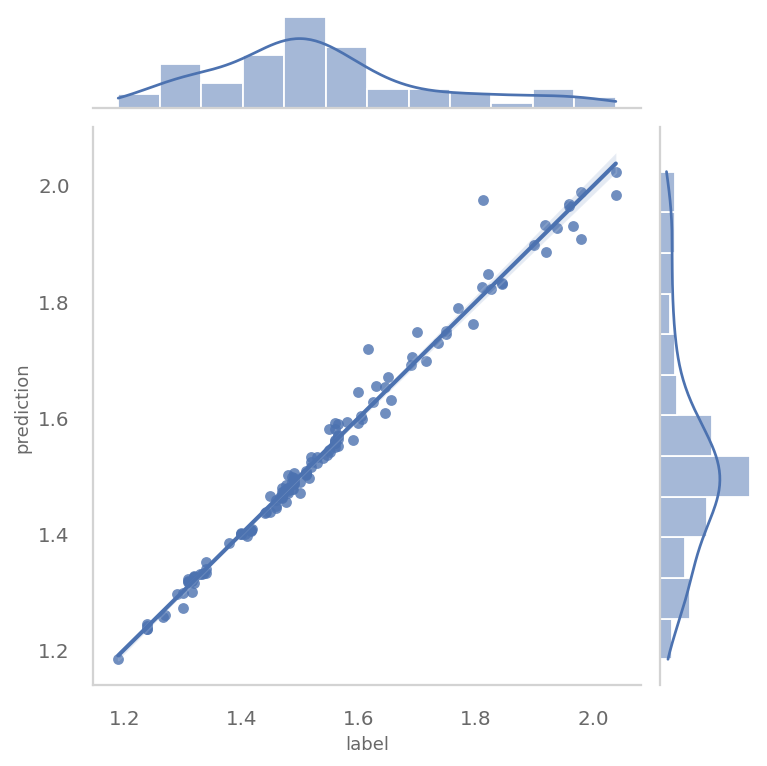

In [ ]:
pred = lr_predictions.select("prediction", "label").toPandas()
sns.jointplot(x=pred["label"], y=pred["prediction"], kind="reg");

### Hyperparameters Tuning

In [25]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit

# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.MaxIter, [60, 80, 100, 120]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

# In this case the estimator is simply the linear regression.
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           trainRatio=0.9)

# Run TrainValidationSplit, and choose the best set of parameters.
tn_model_lr = tvs.fit(training)

In [40]:
tn_model_lr.bestModel.explainParams().split("\n")

['aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)',
 'elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 1.0)',
 'epsilon: The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber (default: 1.35)',
 'featuresCol: features column name. (default: features, current: features)',
 'fitIntercept: whether to fit an intercept term. (default: True, current: True)',
 'labelCol: label column name. (default: label, current: label)',
 'loss: The loss function to be optimized. Supported options: squaredError, huber. (default: squaredError)',
 'maxBlockSizeInMB: maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, depends on specific algorithm

In [43]:
print('Best (regParam): ', tn_model_lr.bestModel.getRegParam())
print('Best (MaxIter): ', tn_model_lr.bestModel.getMaxIter())
print('Best (elasticNetParam): ', tn_model_lr.bestModel.getElasticNetParam())

Best Param (regParam):  0.01
Best Param (MaxIter):  100
Best Param (elasticNetParam):  1.0


In [47]:
tn_lr_predictions = tn_model_lr.bestModel.transform(test)
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2"
)
print("R Squared (R2) on test data = {:.3f}".format(evaluator.evaluate(tn_lr_predictions)))
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse"
)
print("RMSE on test data = {:.3f}".format(evaluator.evaluate(tn_lr_predictions)))

R Squared (R2) on test data = 0.986
RMSE on test data = 0.023


## Random Forest Regression 

In [48]:
from pyspark.ml.regression import RandomForestRegressor

# Define the models
rf = RandomForestRegressor(labelCol="label", featuresCol=assembler.getOutputCol())

# Define the pipeline with the model
pipeline = Pipeline(stages=[season, ohe_season, assembler, rf])

# Fit the pipeline and so train model
model_rf = pipeline.fit(train_df)

# Make predictions
rf_predictions = model_rf.transform(test_df)

# Select example rows to display
rf_predictions.select("prediction", "label", "features").show(5, truncate=False)

# Compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2"
)
print("R Squared (R2) on test data = {:.3f}".format(evaluator.evaluate(rf_predictions)))
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse"
)
print("RMSE on test data = {:.3f}".format(evaluator.evaluate(rf_predictions)))

+------------------+-----+------------------------------------------------------------------+
|prediction        |label|features                                                          |
+------------------+-----+------------------------------------------------------------------+
|1.2071456484446925|1.189|[95.65123772924713,69.0,1.189,1.199,1.199,1.209,1.209,0.0,0.0,1.0]|
|1.2686819963742597|1.239|[95.7866763649355,66.0,1.249,1.259,1.259,1.269,1.249,0.0,0.0,1.0] |
|1.2722435095321545|1.239|[96.17011513652342,66.0,1.239,1.249,1.259,1.259,1.269,0.0,0.0,1.0]|
|1.2639839441119425|1.239|[96.5719810406489,67.0,1.239,1.239,1.249,1.259,1.259,0.0,0.0,1.0] |
|1.22329749576404  |1.239|[97.73568587571661,73.0,1.239,1.209,1.189,1.179,1.175,0.0,0.0,1.0]|
+------------------+-----+------------------------------------------------------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.983
RMSE on test data = 0.025


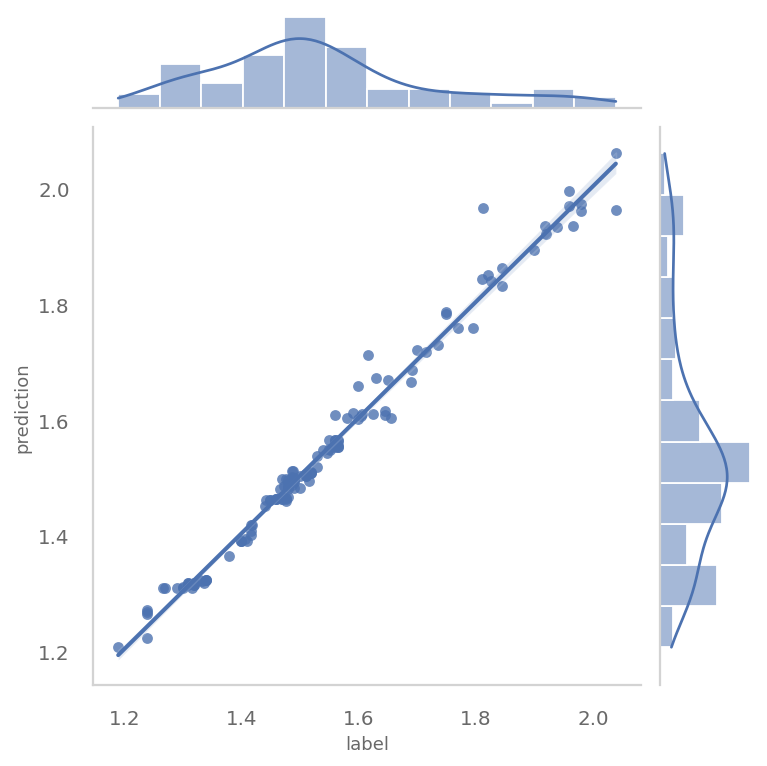

In [49]:
pred = rf_predictions.select("prediction", "label").toPandas()
sns.jointplot(x=pred["label"], y=pred["prediction"], kind="reg");

### Hyperparameters Tuning

In [50]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit

# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [2, 5, 10]) \
    .addGrid(rf.maxBins, [5, 10, 20]) \
    .addGrid(rf.numTrees, [5, 20, 50])\
    .build()

# In this case the estimator is simply the linear regression.
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(estimator=rf,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           trainRatio=0.9)

# Run TrainValidationSplit, and choose the best set of parameters.
tn_model_rf = tvs.fit(training)

In [51]:
tn_model_rf.bestModel.explainParams().split("\n")

['bootstrap: Whether bootstrap samples are used when building trees. (default: True)',
 'cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)',
 'checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)',
 "featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3

In [ ]:
print('Best (maxDepth): ', tn_model_rf.bestModel.getMaxDepth())
print('Best (maxBins): ', tn_model_rf.bestModel.getMaxBins())

In [54]:
tn_rf_predictions = tn_model_rf.bestModel.transform(test)
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2"
)
print("R Squared (R2) on test data = {:.3f}".format(evaluator.evaluate(tn_rf_predictions)))
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse"
)
print("RMSE on test data = {:.3f}".format(evaluator.evaluate(tn_rf_predictions)))

R Squared (R2) on test data = 0.978
RMSE on test data = 0.028


# Conclusion

In this project, I have used the power of **Apache Spark** through the PySpark API. It was of fundamental importance understand how this machine deals with the RAM in order to improve the performance. 

Throughout this notebook I have analysed gas prices collected by all the stations in France almost daily from 2019 on, approx. 17 milions of rows of data. For computational reason I have not included the years from 2016 to 2018

After some important manipulations and cleaning of the data, as well as creating new features, I have constructed a ML pipeline using the library of PySpark **MLlib**. The models were a Linear Regression and a Random Forest, which performed well on the data; the former obtained a slightly less RMSE compared to the latter.

I have performed some basic tuning for showing purpose reasons as a proper one would have take much more time. As expected, the results have not apported greater performance on the model a signal that finer tuning is required.

In [ ]:
spark.catalog.clearCache()